Using device: cuda


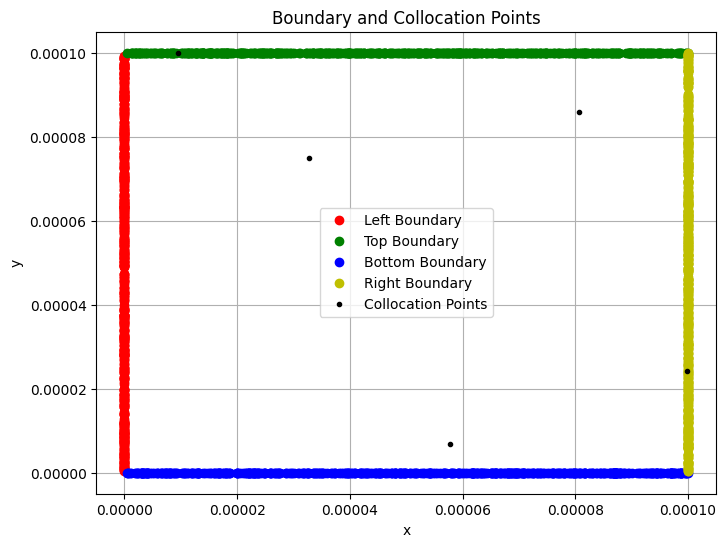

tensor([[5.7670e-05, 6.7256e-06,        inf],
        [9.4918e-06, 9.9889e-05, 1.7889e+20],
        [3.2664e-05, 7.4818e-05,        inf],
        [8.0667e-05, 8.5802e-05,        inf],
        [9.9763e-05, 2.4150e-05,        inf]], device='cuda:0',
       grad_fn=<CatBackward0>)


/home/iitgn-robotics-1/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


<Figure size 640x480 with 0 Axes>

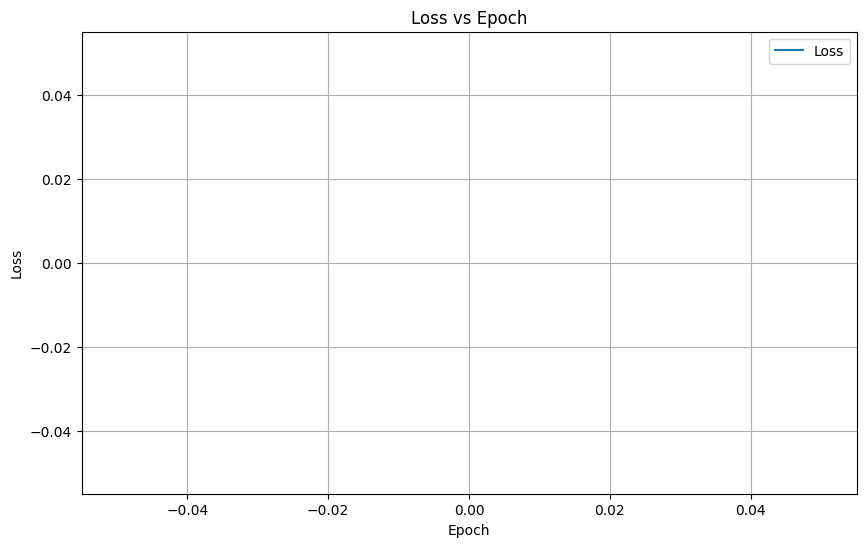

/home/iitgn-robotics-1/.local/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-1-272990b75e07>:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
<ipython-input-1-272990b75e07>:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)


<Figure size 640x480 with 0 Axes>

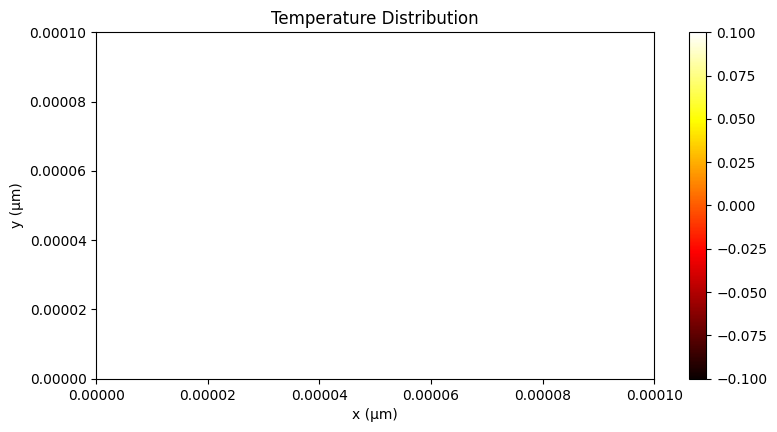

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class PhysicsInformedNN():
    def __init__(self, X_T, X_F):
        # Extracting boundary points for left, right, top, and bottom
        self.x_left = torch.tensor(X_T[X_T[:, 0] == 0, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        
        self.y_left = torch.tensor(X_T[X_T[:, 0] == 0, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)

        self.x_right = torch.tensor(X_T[X_T[:, 0] == 100e-6, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        
        self.y_right = torch.tensor(X_T[X_T[:, 0] == 100e-6, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)

        self.x_top = torch.tensor(X_T[X_T[:, 1] == 100e-6, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        
        self.y_top = torch.tensor(X_T[X_T[:, 1] == 100e-6, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)

        self.x_bottom = torch.tensor(X_T[X_T[:, 1] == 0, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        
        self.y_bottom = torch.tensor(X_T[X_T[:, 1] == 0, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        # x & y collocation points
        self.x_f = torch.tensor(X_F[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)

        self.y_f = torch.tensor(X_F[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)

        # Null vector to test against left:
        self.left_sol = torch.zeros((self.x_left.shape[0], 1), dtype=torch.float32).to(device)
        self.top_sol = torch.zeros((self.x_top.shape[0], 1), dtype=torch.float32).to(device)
        self.right_sol = torch.zeros((self.x_right.shape[0], 1), dtype=torch.float32).to(device)
        self.bottom_sol = torch.zeros((self.x_bottom.shape[0], 1), dtype=torch.float32).to(device)

        self.null = torch.zeros((self.x_f.shape[0], 1), dtype=torch.float32).to(device)

        # Initialize net
        self.create_net()

        # this optimizer updates the weights and biases of the net
        # self.optimizer = torch.optim.LBFGS(self.net.parameters(),
        #                             lr=1,
        #                             max_iter=50000,
        #                             max_eval=50000,
        #                             history_size=50,
        #                             tolerance_grad=1e-5,
        #                             tolerance_change=0.5 * np.finfo(float).eps,
        #                             line_search_fn="strong_wolfe")


        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        # self.optimizer = torch.optim.SGD(self.net.parameters(), lr=0.001)

        # typical MSE loss (this is a loss function)
        self.loss = nn.MSELoss()

        # loss
        self.ls = 0

        self.losses = []

        # iteration number:
        self.iter = 0

        # Constants
        self.domain_size = 100e-6
        self.k = 50  # W/mK
        self.h = 100  # W/m^2K
        self.T_amb = 300  # K
        self.sigma = 5.67e-8  # Stefan-Boltzmann constant
        self.epsilon = 1
        self.A = 0.1
        self.P = 210
        self.r_b = 19.8e-6
        self.lamda = 1.08e-6
        self.k_hat = 4.02
        self.alpha = ((4*np.pi*self.k_hat)/self.lamda)
        


    def create_net(self):
        self.net = nn.Sequential(
            nn.Linear(2, 40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40, 1)
        ).to(device)



    def net_T(self, x, y):
        T = self.net(torch.hstack((x, y)))
        return T

    def net_top(self, x, y):
      T = self.net_T(x,y)
      top = T
      return top

    def net_bc(self, x, y):
      T = self.net_T(x,y)

      T_x = torch.autograd.grad(
          T, x,
          grad_outputs = torch.ones_like(T),
          retain_graph = True,
          create_graph = True
      )[0]

      T_y= torch.autograd.grad(
          T, y,
          grad_outputs = torch.ones_like(T),
          retain_graph = True,
          create_graph = True
      )[0]

      bc = self.k*T_x + self.k*T_y
      return bc


    def net_inside(self, x, y):
        T = self.net_T(x,y)
        # print(f"T_pred_inside:{T}")
        # Q_laser = (2 * self.A * self.P / (np.pi * self.r_b**2)) * torch.exp(-2 * x**2 / self.r_b**2)
        Q_laser = (2 * self.A * self.P / (np.pi * self.r_b**2)) * torch.exp((-2) * (x**2 +(y - 100e-6)**2)/ self.r_b**2) * self.alpha * torch.exp(-self.alpha*(y - 100e-6))
        print(torch.hstack((x,y,Q_laser)))
        # print(Q_laser.shape)
        T_x = torch.autograd.grad(
            T, x,
            grad_outputs = torch.ones_like(T),
            retain_graph = True,
            create_graph = True
        )[0]

        T_xx = torch.autograd.grad(
            T_x, x,
            grad_outputs = torch.ones_like(T_x),
            retain_graph = True,
            create_graph = True
        )[0]

        T_y = torch.autograd.grad(
            T, y,
            grad_outputs = torch.ones_like(T),
            retain_graph = True,
            create_graph = True
        )[0]

        T_yy = torch.autograd.grad(
            T_y, y,
            grad_outputs = torch.ones_like(T_y),
            retain_graph = True,
            create_graph = True
        )[0]

        inside = self.k * (T_xx + T_yy) + Q_laser
        return inside
    
    def closure(self):
        # Reset gradient to zero
        self.optimizer.zero_grad()

        # T prediction at boundary points and collocation points
        T_left_prediction = self.net_bc(self.x_left, self.y_left)
        T_top_prediction = self.net_bc(self.x_top, self.y_top)
        T_right_prediction = self.net_bc(self.x_right, self.y_right)
        T_bottom_prediction = self.net_bc(self.x_bottom, self.y_bottom)
        
        # right_convloss = self.q_convloss(self.x_right, self.y_right)
        # bottom_convloss = self.q_convloss(self.x_bottom, self.y_bottom)

        # Temperature gradient and losses for the inside condition
        T_inside_prediction = self.net_inside(self.x_f, self.y_f)
        F_loss_inside = self.loss(T_inside_prediction, self.null)

        # losses for the boundary conditions
        T_left_loss = self.loss(T_left_prediction, self.left_sol)
        T_top_loss = self.loss(T_top_prediction, self.top_sol)
        T_right_loss = self.loss(T_right_prediction, self.right_sol)
        T_bottom_loss = self.loss(T_bottom_prediction, self.bottom_sol)

        self.ls = T_top_loss + T_left_loss + T_right_loss + T_bottom_loss + F_loss_inside
        self.losses.append(self.ls.item())
        # print(f"T_top_loss: {T_top_loss}")
        # print(f"T_left_loss: {T_left_loss}")
        # print(f"T_right_loss: {T_right_loss}")
        # print(f"T_bottom_loss: {T_bottom_loss}")
        # print(f"F_loss: {F_loss_inside}")

        # Check for NaN values
        # if torch.isnan(self.ls):
        #     print("Loss is NaN. Stopping training.")
        #     print(f"T_left_prediction: {T_left_prediction}")
        #     print(f"T_top_prediction: {T_top_prediction}")
        #     print(f"T_right_prediction: {T_right_prediction}")
        #     print(f"T_bottom_prediction: {T_bottom_prediction}")
        #     print(f"T_inside_prediction: {T_inside_prediction}")
        #     return self.ls

        # derivative with respect to net's weights
        self.ls.backward()
        self.optimizer.step()
        # increase iteration count
        self.iter += 1

        # print report:
        if not self.iter % 10:
            print('Epoch: {0:}, Total Loss: {1:6.3f}'.format(self.iter, self.ls) + f" Top_loss: {T_top_loss} Right loss: {T_right_loss} Left loss: {T_left_loss}  Bottom loss: {T_bottom_loss}  Inside loss: {F_loss_inside} device {device}")
        return self.ls

    def train(self, epochs=1):
        """Training Loop"""
        self.net.train()
        for _ in range(epochs):
            self.closure()
        self.plot_losses()


    def predict(self, x, y):
        self.net.eval()
        x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
        y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
        T = self.net_T(x, y)
        return T

    def plot(self):
      x = torch.linspace(0, self.domain_size, 1000).to(device)
      y = torch.linspace(0, self.domain_size, 1000).to(device)

      # x & y grids
      X, Y = torch.meshgrid(x, y)

      # x & t column
      xcol = X.reshape(-1, 1)
      ycol = Y.reshape(-1, 1)

      # one large column
      tsol = self.predict(xcol, ycol)

      # reshape solution
      T = tsol.reshape(x.numel(), y.numel())
      
      sol_vect = torch.hstack((xcol, ycol, tsol))

      # Transform to numpy
      xnp = x.cpu().numpy()
      ynp = y.cpu().numpy()
      Tnp = T.cpu().detach().numpy()

      # plot
      fig = plt.figure(figsize=(9, 4.5))
      ax = fig.add_subplot(111)

      h = ax.imshow(Tnp,
                    interpolation='nearest',
                    cmap='hot',
                    extent=[0, self.domain_size, 0, self.domain_size],
                    origin='lower', aspect='auto')
      plt.colorbar(h, ax=ax)
      ax.set_xlabel('x (µm)')
      ax.set_ylabel('y (µm)')
      ax.set_title('Temperature Distribution')
      plt.show()
      plt.savefig('/home/iitgn-robotics-1/Desktop/Steady State Temperature Field Prediction/problem2/model_result.png')

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.losses) + 1), self.losses, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig('/home/iitgn-robotics-1/Desktop/Steady State Temperature Field Prediction/problem2/loss_V_epoch.png')

    def save_model(self, file_path):
      torch.save(self.net.state_dict(), file_path)

    def load_model(self, file_path):
      self.net.load_state_dict(torch.load(file_path))



if __name__ == "__main__":
    N_T = 2000  # Number of datapoints
    N_F = 5 # Number of collocation points
    domain_size = 100e-6 # 100 micrometers

    # Left Boundary Points
    x_left = np.zeros((N_T//4, 1), dtype=float)
    y_left = np.random.uniform(0, domain_size, (N_T//4, 1))
    X_left = np.hstack((x_left, y_left))

    # Top Boundary Points
    x_top = np.random.uniform(0, domain_size, (N_T//4, 1))
    y_top = np.full((N_T//4, 1),100e-6, dtype = float)
    X_top = np.hstack((x_top, y_top))

    # Bottom Boundary Points
    x_bottom = np.random.uniform(0, domain_size, (N_T//4, 1))
    y_bottom = np.zeros((N_T//4 , 1), dtype=float)
    X_bottom = np.hstack((x_bottom, y_bottom))

    # Right Boundary Points
    x_right = np.full((N_T//4, 1), 100e-6, dtype=float)
    y_right = np.random.uniform(0, domain_size, (N_T//4, 1))
    X_right = np.hstack((x_right, y_right))

    X_T_train = np.vstack((X_left, X_top, X_bottom, X_right))

    # shuffle X_T_train:
    index = np.arange(0, N_T)
    np.random.shuffle(index)
    X_T_train = X_T_train[index, :]

    # Make X_F_train
    X_F_train = np.zeros((N_F, 2), dtype=float)
    for row in range(N_F):
        x = np.random.uniform(0, domain_size)
        y = np.random.uniform(0, domain_size)
        X_F_train[row, 0] = x
        X_F_train[row, 1] = y

    # # add the boundary points to collocation points
    # X_F_train = np.vstack((X_F_train, X_T_train))

    # Plotting the boundary points and collocation points
    plt.figure(figsize=(8, 6))
    plt.plot(X_left[:, 0], X_left[:, 1], 'ro', label='Left Boundary')
    plt.plot(X_top[:, 0], X_top[:, 1], 'go', label='Top Boundary')
    plt.plot(X_bottom[:, 0], X_bottom[:, 1], 'bo', label='Bottom Boundary')
    plt.plot(X_right[:, 0], X_right[:, 1], 'yo', label='Right Boundary')
    plt.plot(X_F_train[:, 0], X_F_train[:, 1], 'k.', label='Collocation Points')  # Plot collocation points in black
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Boundary and Collocation Points')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('/home/iitgn-robotics-1/Desktop/Steady State Temperature Field Prediction/problem2/boundary_points.png')

    pinn = PhysicsInformedNN(X_T_train, X_F_train)
    pinn.train()
    # pinn.load_model('/home/iitgn-robotics-1/Desktop/Steady State Temperature Field Prediction/mode_0.pth')
    pinn.plot()
    pinn.save_model('model_2.pth')

In [ ]:
print(torch.exp(1))

TypeError: exp(): argument 'input' (position 1) must be Tensor, not int

In [ ]:
print(torch.exp(torch.tensor(4360.84)))

tensor(inf)
